<a href="https://colab.research.google.com/github/thaCripple/SkinLesionClassifier_v2/blob/main/slc_v2_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing the performance of the 3 trained models
I want to compare:
* Predictive capacity
* Inference time

I will perform multiple runs over the test dataset and analyze the achieved metrics

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchvision.transforms import v2
from pathlib import Path
import time
from PIL import Image
from pathlib import Path
import os

In [ ]:
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Load just the test images into session storage
if not Path("/content/skin_lesions.zip").is_file():
  !cp "/content/drive/MyDrive/skin_lesions.zip" "/content"
if not Path("/content/skin_lesions").is_dir():
  # Syntax here is !command, not verbose, "archive_file", "all files from this folder", -d(estination) "where to extract"
  !unzip -q "/content/skin_lesions.zip" "skin_lesions/test/*" -d "/content"

In [ ]:
# Load light models into session storage
if not Path("/content/slc_v2_models_light.zip").is_file():
  !cp "/content/drive/MyDrive/skin_lesion_classifier_v2/slc_v2_models_light.zip" "/content"
if not Path("/content/light_models").is_dir():
  !unzip "/content/slc_v2_models_light.zip" -d "/content/light_models"

# Create containers for models

In [ ]:
class ModelSubject:
  """
  # Attributes:
  model_compiled - fine-tuned model architecture that has been torch.compiled and optimized with lightning.fabric
  model_light  - fine-tuned model architecture that has NOT been torch.compiled and optimized with lightning.fabric
  """
  def __init__(self, name:str) -> None:
    self.name = name
    self.model_light = None
    self.transforms = None
    self.test_ds = None
    self.test_dl = None
    self.predictions_light = None
    self.time_taken = None
    self.single_sample_time = None
    self.metrics = None
    self.clsf_report = None

In [ ]:
subjects = []
effnet_b0 = ModelSubject(name="EfficientNet_b0")
subjects.append(effnet_b0)
effnet_b3 = ModelSubject(name="EfficientNet_b3")
subjects.append(effnet_b3)
maxvit_t = ModelSubject(name="MaxViT_t")
subjects.append(maxvit_t)
subjects

## Add model specific transforms

In [ ]:
effnet_b0.transforms = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1.transforms
effnet_b3.transforms = torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1.transforms
maxvit_t.transforms = torchvision.models.MaxVit_T_Weights.IMAGENET1K_V1.transforms

## Add fine-tuned models

In [ ]:
light_models_dir = Path("/content/light_models")

In [ ]:
effnet_b0.model_light = torch.load(f=Path(light_models_dir, "effnet_b0_model_light.pth"), weights_only=False)
effnet_b3.model_light = torch.load(f=Path(light_models_dir, "effnet_b3_model_light.pth"), weights_only=False)
maxvit_t.model_light = torch.load(f=Path(light_models_dir, "maxvit_t_model_light.pth"), weights_only=False)

## Create dataloaders for each model

In [ ]:
BATCH_SIZE = 128
WORKERS = os.cpu_count()

In [ ]:
for subject in subjects:
  subject.test_ds = torchvision.datasets.ImageFolder(root=Path("/content/skin_lesions/test"), transform=subject.transforms())
  subject.test_dl = torch.utils.data.DataLoader(dataset=subject.test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, prefetch_factor=1)

# Set-up the evaluation

## Get predictions on the test set
Also log the time taken to complete the run



In [ ]:
def get_predictions(model):
  num_batches = len(model.test_dl)

  start_time = time.time()
  model.model_light.eval()
  with torch.inference_mode():
    batched_predictions = []
    for batch_num, (x_batch, _) in enumerate(model.test_dl):

      if batch_num % 3 == 0:
        print(f" Batch {batch_num}/{num_batches}")

      batch_logits = model.model_light(x_batch)
      batch_predictions = torch.argmax(batch_logits, dim=1)
      batched_predictions.append(batch_predictions)
  total_time = time.time() - start_time
  print(f"-- {subject.name} finished after {total_time:.2f}s --")

  return torch.cat(batched_predictions, dim=0), total_time

In [ ]:
for subject in subjects:
  subject.predictions_light, subject.time_taken = get_predictions(model=subject)

 Batch 0/48
 Batch 8/48
 Batch 16/48
 Batch 24/48
 Batch 32/48
 Batch 40/48
-- EfficientNet_b0 finished after 150.81s --
 Batch 0/48
 Batch 8/48
 Batch 16/48
 Batch 24/48
 Batch 32/48
 Batch 40/48
-- EfficientNet_b3 finished after 592.28s --
 Batch 0/48
 Batch 8/48
 Batch 16/48
 Batch 24/48
 Batch 32/48
 Batch 40/48
-- MaxViT_t finished after 803.96s --


## Create metrics of each model's performance

## Calculate the class weights

In [ ]:
maxvit_t.test_ds.class_to_idx

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [ ]:
maxvit_t.test_ds.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [ ]:
y_test = maxvit_t.test_ds.targets
class_labels = np.unique(y_test)
class_labels

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_test)
class_weights

array([5.01993355, 2.32104455, 0.99473338, 4.90584416, 1.26232247,
       0.23772813, 6.16734694])

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 43,  93, 217,  44, 171, 908,  35]))

### Create an array for the `sample_weight` argument in `classification_report`

In [ ]:
y_test[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
sample_weight_ar = np.array([class_weights[sample] for sample in y_test])
sample_weight_ar[:10]

array([5.01993355, 5.01993355, 5.01993355, 5.01993355, 5.01993355,
       5.01993355, 5.01993355, 5.01993355, 5.01993355, 5.01993355])

In [ ]:
for subject in subjects:
  subject.metrics = classification_report(y_true=y_test, y_pred=subject.predictions_light, target_names=maxvit_t.test_ds.classes, sample_weight=sample_weight_ar, output_dict=True)
  subject.clsf_report = classification_report(y_true=y_test, y_pred=subject.predictions_light, target_names=maxvit_t.test_ds.classes, sample_weight=sample_weight_ar, output_dict=False)

## Create a DataFrame with the metrics

In [ ]:
effnet_b0_df = pd.DataFrame(effnet_b0.metrics)
effnet_b3_df = pd.DataFrame(effnet_b3.metrics)
maxvit_df = pd.DataFrame(maxvit_t.metrics)

In [ ]:
metrics_df = pd.concat([effnet_b0_df, effnet_b3_df, maxvit_df], axis=0, keys=["effnet_b0", "effnet_b3", "maxvit"])
metrics_df

akiec         bcc         bkl          df  \
effnet_b0 precision    0.989362    1.000000    1.000000    1.000000   
          recall       1.000000    0.989247    0.990783    1.000000   
          f1-score     0.994652    0.994595    0.995370    1.000000   
          support    215.857143  215.857143  215.857143  215.857143   
effnet_b3 precision    1.000000    1.000000    0.992014    0.998900   
          recall       1.000000    1.000000    1.000000    1.000000   
          f1-score     1.000000    1.000000    0.995991    0.999450   
          support    215.857143  215.857143  215.857143  215.857143   
maxvit    precision    0.995413    1.000000    0.997792    0.992014   
          recall       1.000000    1.000000    0.995392    1.000000   
          f1-score     0.997701    1.000000    0.996590    0.995991   
          support    215.857143  215.857143  215.857143  215.857143   

                            mel          nv        vasc  accuracy  \
effnet_b0 precision    0.996648    0.973853    1.000000  0.994169   
          recall       0.982456    0.996696    1.000000  0.994169   
          f1-score     0.989501    0.985142    1.000000  0.994169   
          support    215.857143  215.857143  215.857143  0.994169   
effnet_b3 precision    0.998893    1.000000    1.000000  0.998535   
          recall       0.994152    0.995595    1.000000  0.998535   
          f1-score     0.996517    0.997792    1.000000  0.998535   
          support    215.857143  215.857143  215.857143  0.998535   
maxvit    precision    0.994326    0.971315    1.000000  0.992913   
          recall       0.964912    0.990088    1.000000  0.992913   
          f1-score     0.979398    0.980612    1.000000  0.992913   
          support    215.857143  215.857143  215.857143  0.992913   

                       macro avg  weighted avg  
effnet_b0 precision     0.994266      0.994266  
          recall        0.994169      0.994169  
          f1-score      0.994180      0.994180  
          support    1511.000000   1511.000000  
effnet_b3 precision     0.998544      0.998544  
          recall        0.998535      0.998535  
          f1-score      0.998536      0.998536  
          support    1511.000000   1511.000000  
maxvit    precision     0.992980      0.992980  
          recall        0.992913      0.992913  
          f1-score      0.992899      0.992899  
          support    1511.000000   1511.000000

## Check the time needed to predict a single sample

In [ ]:
def time_single_sample(subject):
  img = Image.open(Path("/content/sample1.jpg"))
  transform = subject.transforms() # Need to save to variable first apparently o.O
  sample = torch.unsqueeze(input=transform(img), dim=0)

  start_time = time.time()
  subject.model_light.eval()
  with torch.inference_mode():
    prediction = torch.argmax(subject.model_light(sample), dim=1)
    predicted_class = subject.test_ds.classes[prediction]
  time_taken = time.time() - start_time
  print(f"{subject.name} predicted {predicted_class} after {time_taken:.3f}s")

  return time_taken

In [ ]:
for subject in subjects:
  subject.single_sample_time = time_single_sample(subject=subject)

EfficientNet_b0 predicted bkl after 0.108s
EfficientNet_b3 predicted mel after 0.308s
MaxViT_t predicted bkl after 0.617s


Umm, that was a picture of my mole. What do you mean B3 predicted melanoma!?

In [ ]:
metrics_df.index.levels[0]

Index(['effnet_b0', 'effnet_b3', 'maxvit'], dtype='object')

In [ ]:
times_data = {}
for i in range(len(subjects)):
  key = metrics_df.index.levels[0][i]
  times_data[key] = [subjects[i].time_taken, subjects[i].single_sample_time]
times_data

{'effnet_b0': [150.81428599357605, 0.10756731033325195],
 'effnet_b3': [592.2787184715271, 0.3081529140472412],
 'maxvit': [803.9562208652496, 0.6165168285369873]}

In [ ]:
times_df = pd.DataFrame(data=times_data).T
times_df.columns=["total_time", "single_sample_time"]
times_df

,total_time,single_sample_time
effnet_b0,150.814286,0.107567
effnet_b3,592.278718,0.308153
maxvit,803.956221,0.616517


# Save the dataframes for later analysis
I gotta get to work!

In [ ]:
metrics_df.to_csv("metrics.csv")

NameError: name 'metrics_df' is not defined

In [ ]:
metrics_df = pd.read_csv("/content/metrics.csv", index_col=[0, 1])
metrics_df

akiec         bcc         bkl          df  \
effnet_b0 precision    0.989362    1.000000    1.000000    1.000000   
          recall       1.000000    0.989247    0.990783    1.000000   
          f1-score     0.994652    0.994595    0.995370    1.000000   
          support    215.857143  215.857143  215.857143  215.857143   
effnet_b3 precision    1.000000    1.000000    0.992014    0.998900   
          recall       1.000000    1.000000    1.000000    1.000000   
          f1-score     1.000000    1.000000    0.995991    0.999450   
          support    215.857143  215.857143  215.857143  215.857143   
maxvit    precision    0.995413    1.000000    0.997792    0.992014   
          recall       1.000000    1.000000    0.995392    1.000000   
          f1-score     0.997701    1.000000    0.996590    0.995991   
          support    215.857143  215.857143  215.857143  215.857143   

                            mel          nv        vasc  accuracy  \
effnet_b0 precision    0.996648    0.973853    1.000000  0.994169   
          recall       0.982456    0.996696    1.000000  0.994169   
          f1-score     0.989501    0.985142    1.000000  0.994169   
          support    215.857143  215.857143  215.857143  0.994169   
effnet_b3 precision    0.998893    1.000000    1.000000  0.998535   
          recall       0.994152    0.995595    1.000000  0.998535   
          f1-score     0.996517    0.997792    1.000000  0.998535   
          support    215.857143  215.857143  215.857143  0.998535   
maxvit    precision    0.994326    0.971315    1.000000  0.992913   
          recall       0.964912    0.990088    1.000000  0.992913   
          f1-score     0.979398    0.980612    1.000000  0.992913   
          support    215.857143  215.857143  215.857143  0.992913   

                       macro avg  weighted avg  
effnet_b0 precision     0.994266      0.994266  
          recall        0.994169      0.994169  
          f1-score      0.994180      0.994180  
          support    1511.000000   1511.000000  
effnet_b3 precision     0.998544      0.998544  
          recall        0.998535      0.998535  
          f1-score      0.998536      0.998536  
          support    1511.000000   1511.000000  
maxvit    precision     0.992980      0.992980  
          recall        0.992913      0.992913  
          f1-score      0.992899      0.992899  
          support    1511.000000   1511.000000

In [ ]:
times_df.to_csv("times.csv")

In [ ]:
times_df = pd.read_csv("/content/times.csv", index_col=[0])
times_df

,total_time,single_sample_time
effnet_b0,150.814286,0.107567
effnet_b3,592.278718,0.308153
maxvit,803.956221,0.616517


In [ ]:
metrics_df.xs(key=("precision"), level=1, axis=0)[['accuracy', "weighted avg"]]

,accuracy,weighted avg
effnet_b0,0.994169,0.994266
effnet_b3,0.998535,0.998544
maxvit,0.992913,0.992980


# Analysis of the resulting metrics
Pandas and seaborn/matplotlib practice really 😉

In [ ]:
sns.set(style="whitegrid", palette="colorblind")

## Plot Accuracy, Precision and f1-scores of each model

In [ ]:
precision_df = metrics_df.xs(key=("precision"), level=1, axis=0)["weighted avg"]
precision_df

,weighted avg
effnet_b0,0.994266
effnet_b3,0.998544
maxvit,0.992980


In [ ]:
f1_df = metrics_df.xs(key=("f1-score"), level=1, axis=0)["weighted avg"]
f1_df

,weighted avg
effnet_b0,0.994180
effnet_b3,0.998536
maxvit,0.992899


In [ ]:
accuracy_df = metrics_df.xs(key=("precision"), level=1, axis=0)['accuracy']
accuracy_df

,accuracy
effnet_b0,0.994169
effnet_b3,0.998535
maxvit,0.992913


In [ ]:
subs1 = pd.concat(objs=[precision_df, f1_df, accuracy_df], axis=0, keys=["precision", "f1_score", "accuracy"])
subs1 = subs1.reset_index().set_index("level_1")
subs1.columns = ["metric", "value"]
subs1.index.name = "model"
subs1

,metric,value
model,,
effnet_b0,precision,0.994266
effnet_b3,precision,0.998544
maxvit,precision,0.992980
effnet_b0,f1_score,0.994180
effnet_b3,f1_score,0.998536
maxvit,f1_score,0.992899
effnet_b0,accuracy,0.994169
effnet_b3,accuracy,0.998535
maxvit,accuracy,0.992913


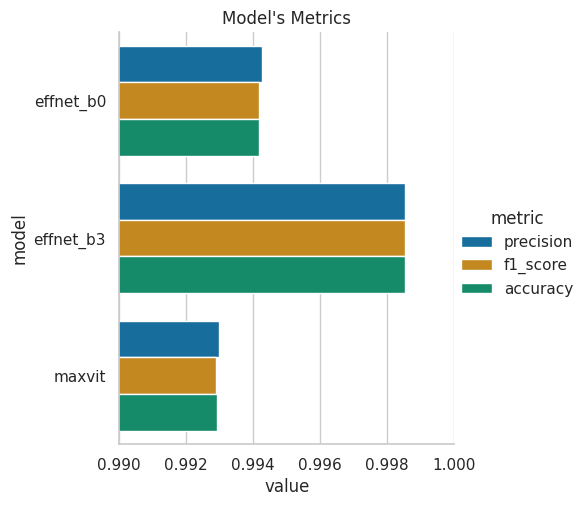

In [ ]:
plot1 = sns.catplot(kind="bar", data=subs1, y="model", x="value", hue="metric")
plot1.set(xlim=(.99, 1), title="Model's Metrics")

## Analyze prediction times on a CPU without using `torch.compile()` or `lightning.Fabric`

In [ ]:
times_df

,total_time,pct_from_b0,single_sample_time,model_size,pct_more
effnet_b0,150.814286,1.000000,0.107567,16.4,1.000000
effnet_b3,592.278718,2.864745,0.308153,43.5,2.864745
maxvit,803.956221,5.731452,0.616517,122.6,5.731452


## Calculate the % difference in the time taken to perform a single prediciton

In [ ]:
times_df["single_sample_time"]

,single_sample_time
effnet_b0,0.107567
effnet_b3,0.308153
maxvit,0.616517


In [ ]:
times_df["single_sample_time"].apply(func=lambda t: t/times_df["single_sample_time"])

,effnet_b0,effnet_b3,maxvit
effnet_b0,1.000000,0.349071,0.174476
effnet_b3,2.864745,1.000000,0.499829
maxvit,5.731452,2.000685,1.000000


In [ ]:
times_df.insert(loc=2, column="pct_from_b0", value=times_df["single_sample_time"].apply(func=lambda t: t/times_df["single_sample_time"])["effnet_b0"])

In [ ]:
times_df

,total_time,single_sample_time,pct_from_b0,model_size
effnet_b0,150.814286,0.107567,1.000000,16.4
effnet_b3,592.278718,0.308153,2.864745,43.5
maxvit,803.956221,0.616517,5.731452,122.6


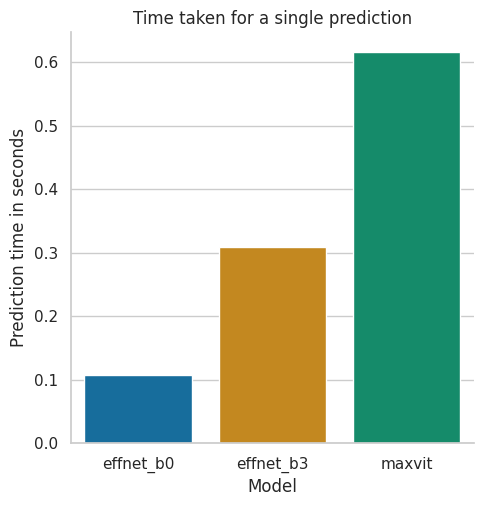

In [ ]:
times_plot = sns.catplot(kind="bar", x=times_df.index, y=times_df["single_sample_time"], hue=times_df.index)
times_plot.ax.set(xlabel="Model", ylabel="Prediction time in seconds", title="Time taken for a single prediction")
times_plot

## Add model sizes in `MB`

In [ ]:
times_df["model_size"] = [16.4, 43.5, 122.6]
times_df

,total_time,single_sample_time,pct_from_b0,model_size
effnet_b0,150.814286,0.107567,1.000000,16.4
effnet_b3,592.278718,0.308153,2.864745,43.5
maxvit,803.956221,0.616517,5.731452,122.6


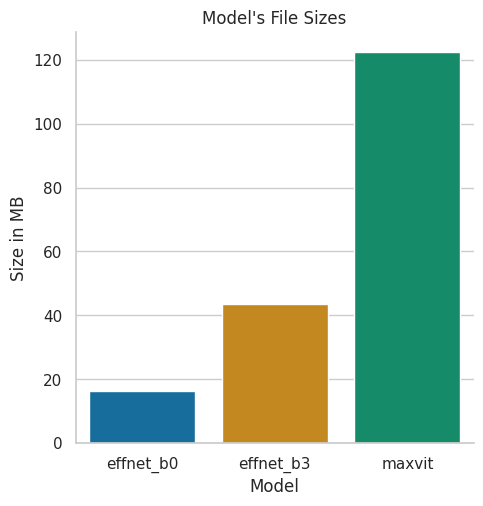

In [ ]:
sizes_plot = sns.catplot(kind="bar", x=times_df.index, y=times_df["model_size"], hue=times_df.index)
sizes_plot.ax.set(xlabel="Model", ylabel="Size in MB", title="Model's File Sizes")
sizes_plot